# Analyse der Buchungstrends von Airbnb in New York City

**Ziel**: Die Buchungstrends von Airbnb in New York City zu entschlüsseln und die Hauptfaktoren zu identifizieren, die die Auslastung von Airbnb-Unterkünften in diesem internationalen Tourismushotspot beeinflussen.

## Methodik:
- **Visuelle Datenanalyse**: Einführung in die Trends und Muster der Daten.
- **Durchführung statistischer Tests**: Identifizierung signifikanter Merkmale.
- **Einsatz des Random Forest-Vorhersagemodells**: Bestimmung der Schlüsselfaktoren für die Buchungsfrequenz.

## Kernfrage:
Mit einem besonderen Fokus auf den Angeboten in NYC möchten wir herausfinden: Welche Airbnb-Unterkünfte erfreuen sich besonderer Beliebtheit und warum?

# Datenimport und -vorbereitung

In diesem Abschnitt werden wir den Airbnb-Datensatz laden und vorbereiten, um die Analyse zu erleichtern. Die Vorbereitung umfasst das Ersetzen von Leerzeichen in Spaltennamen, das Filtern von relevanten Spalten, das Umwandeln bestimmter Datenfelder und das Löschen von Spalten mit fehlden Einträgen.

In [25]:
# Importieren der erforderlichen Bibliotheken
import pandas as pd

# Datensatz laden
airbnb_data = pd.read_csv('Airbnb_Open_Data.csv',  low_memory=False)

# Ersetzen von Leerzeichen durch Unterstriche für alle Spaltennamen
airbnb_data.columns = [col.replace(' ', '_') for col in airbnb_data.columns]

# Entfernen von Währungszeichen und Umwandlung in float
airbnb_data['price'] = airbnb_data['price'].str.replace('$', '').str.replace(',', '').astype(float)
airbnb_data['service_fee'] = airbnb_data['service_fee'].str.replace('$', '').str.replace(',', '').astype(float)

# Umwandlung von bestimmten Spalten in den Datentyp 'category'
airbnb_data['cancellation_policy'] = airbnb_data['cancellation_policy'].astype('category')
airbnb_data['neighbourhood'] = airbnb_data['neighbourhood'].astype('category')
airbnb_data['room_type'] = airbnb_data['room_type'].astype('category')
airbnb_data['instant_bookable'] = airbnb_data['instant_bookable'].astype('category')
airbnb_data['host_identity_verified'] = airbnb_data['host_identity_verified'].astype('category')

# Auswahl bestimmter relevanter Spalten für die weitere Analyse
selected_columns = ['id', 'host_identity_verified', 'neighbourhood', 'number_of_reviews', 'instant_bookable', 
                    'room_type', 'availability_365', 'minimum_nights', 'reviews_per_month', 'price', 
                    'service_fee', 'cancellation_policy']

airbnb_data = airbnb_data[selected_columns]

categorical_columns = ['host_identity_verified', 'instant_bookable', 'room_type', 'cancellation_policy']
numerical_columns = ['number_of_reviews', 'availability_365', 'minimum_nights', 'reviews_per_month', 'price', 'service_fee']


# Datenbereinigung: Entfernen von Zeilen mit NaN oder Inf in den relevanten Spalten
airbnb_data = airbnb_data.dropna(subset=numerical_columns)


# Outlier-Analyse

Ausreißer (Outliers) sind Werte, die erheblich von anderen Beobachtungen in einem Datensatz abweichen. Das Vorhandensein von Ausreißern kann die Ergebnisse einer Analyse verfälschen und Modelle ungenau machen. Daher ist es oft notwendig, sie zu identifizieren und zu behandeln.

Es gibt verschiedene Methoden zur Identifikation von Ausreißern, aber nicht alle Ausreißer sind in jedem Kontext problematisch. In diesem Abschnitt verwenden wir zwei gängige Methoden zur Outlier-Erkennung:

1. **Z-Score Methode**: Der Z-Score gibt an, wie viele Standardabweichungen ein Datenpunkt vom Mittelwert entfernt ist. Ein hoher Z-Score weist auf einen potenziellen Ausreißer hin.
2. **IQR Methode (Interquartilsabstand)**: Hierbei wird der Bereich zwischen dem 1. und 3. Quartil eines Datensatzes betrachtet. Werte, die diesen Bereich um das 1,5-fache des IQR überschreiten, gelten als Ausreißer.

Um die Genauigkeit unserer Ausreißererkennung zu erhöhen, identifizieren wir Ausreißer mithilfe BEIDER Methoden und entfernen nur die Datenpunkte, die in beiden Methoden als Ausreißer identifiziert werden. Dadurch wird das Risiko minimiert, gültige Datenpunkte versehentlich zu entfernen.


In [26]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Z-Score Methode zur Identifikation von Ausreißern
def identify_outliers_zscore(data, threshold=3):
    z_scores = zscore(data)
    outliers = np.abs(z_scores) > threshold
    return outliers

# IQR Methode zur Identifikation von Ausreißern
def identify_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

# Annahme: 'numerical_columns' ist eine Liste der numerischen Spalten in 'airbnb_data'
for column in numerical_columns:
    
    # Identifiziere Ausreißer mit der Z-Score Methode
    outliers_zscore = identify_outliers_zscore(airbnb_data[column])
    
    # Identifiziere Ausreißer mit der IQR Methode
    outliers_iqr = identify_outliers_iqr(airbnb_data[column])
    
    # Finde Datenpunkte, die in BEIDEN Methoden als Ausreißer identifiziert wurden
    combined_outliers = outliers_zscore & outliers_iqr
    
    # Entferne diese Ausreißer aus dem Datensatz
    airbnb_data = airbnb_data[~combined_outliers]


# Bivariate Analyse

Die bivariate Analyse erlaubt uns, die Beziehung zwischen zwei Variablen zu betrachten. In diesem Fall betrachten wir die Beziehung zwischen kategorialen Variablen und der Verfügbarkeit (gemessen an der Anzahl der verfügbaren Tage im Jahr).

## Host Identitätsüberprüfung vs. Verfügbarkeit

- **Unbestätigt vs. Bestätigt**: Es scheint, dass die Verfügbarkeit zwischen Hosts mit bestätigter Identität und denen ohne bestätigte Identität ähnlich ist.

## Sofort buchbar vs. Verfügbarkeit

- **Falsch vs. Wahr**: Auch hier gibt es kaum Unterschied in der Verfügbarkeit zwischen den Einträgen, die sofort buchbar sind, und denen, die es nicht sind.

## Zimmertyp vs. Verfügbarkeit

- **Ganze Wohnung/Haus, Hotelzimmer, Privatzimmer, Gemeinsames Zimmer**: Der Boxplot zeigt, dass Hotelzimmer tendenziell eine höhere Medianauf Verfügbarkeit haben als andere Zimmerarten.

## Stornierungsrichtlinie vs. Verfügbarkeit

- **Flexibel, Moderat, Streng**: Die Verfügbarkeit scheint zwischen den verschiedenen Stornierungsrichtlinien gleich zu sein.


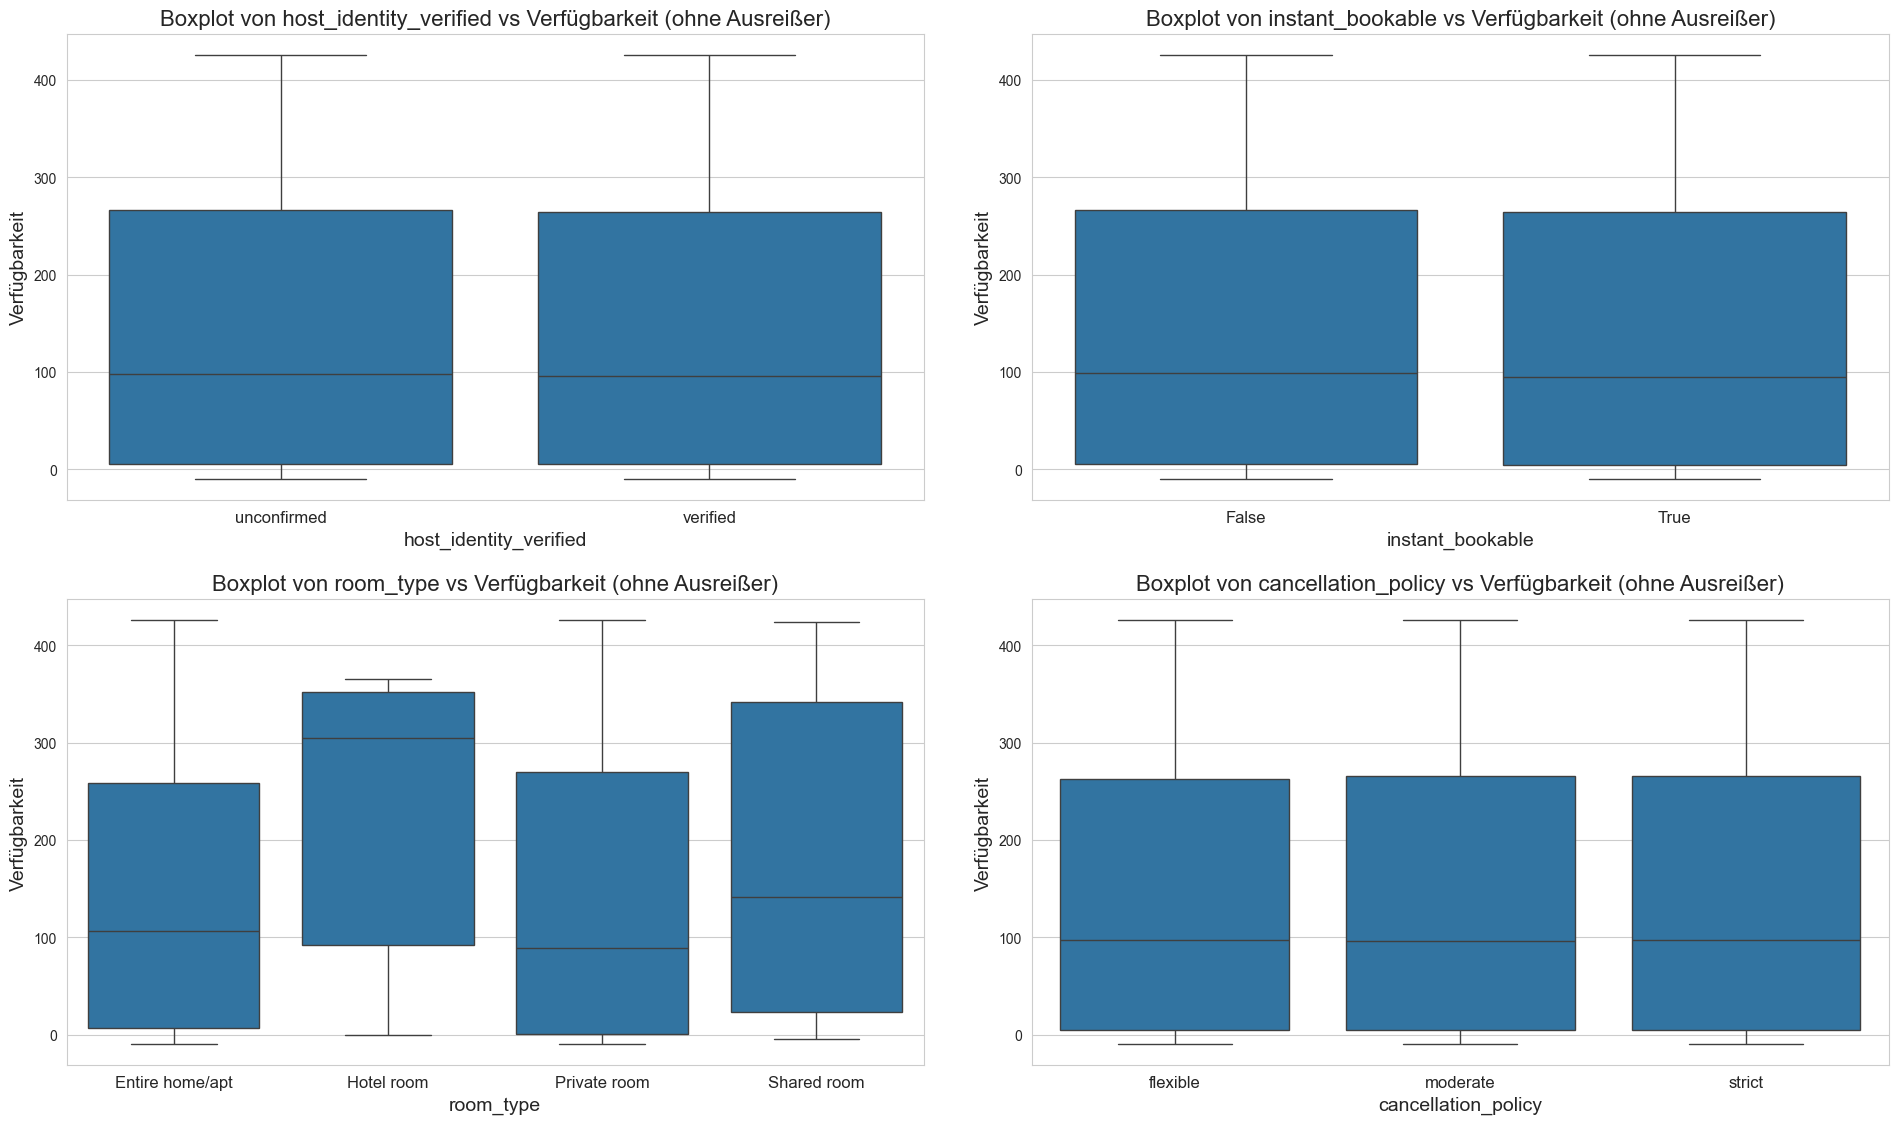

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste der kategorialen Variablen
categorical_columns = ['host_identity_verified', 'instant_bookable', 'room_type', 'cancellation_policy']

# Boxplots für kategoriale Variablen vs. Verfügbarkeit
# 2x2-Grid für die Boxplots erstellen
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.tight_layout(pad=5.0)

for i, column in enumerate(categorical_columns):
    row = i // 2
    col = i % 2
    sns.boxplot(x=column, y='availability_365', data=airbnb_data, showfliers=False, ax=axes[row, col])
    
    # Schriftgröße des Titels und der Achsenbeschriftungen
    axes[row, col].set_title(f'Boxplot von {column} vs Verfügbarkeit (ohne Ausreißer)', fontsize=16)
    axes[row, col].set_xlabel(column, fontsize=14)
    axes[row, col].set_ylabel('Verfügbarkeit', fontsize=14)
    
    # Anpassung der x-Ticks
    axes[row, col].set_xticks(axes[row, col].get_xticks())
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=0, fontsize=12)

plt.show()

## Multivariate Analyse

Die multivariate Analyse zielt darauf ab, die Beziehungen zwischen mehreren Variablen gleichzeitig zu verstehen und zu interpretieren. Eine der effektivsten Techniken, um diese Art von Beziehung in einem Datensatz zu visualisieren, ist die Heatmap. Die vorgelegte Heatmap zeigt die Korrelationskoeffizienten zwischen den Variablen unseres Airbnb-Datensatzes.

#### Schlüsselbeobachtungen:

- Eine starke positive Korrelation (0.60) zwischen der "Anzahl der Bewertungen" und der "Verfügbarkeit (365 Tage)" deutet darauf hin, dass Unterkünfte, die häufiger verfügbar sind, tendenziell mehr Bewertungen erhalten.
  
- "Bewertungen pro Monat" und "Anzahl der Bewertungen" weisen eine positive Korrelation (0.07) auf, diese Beziehung ist jedoch schwach.
  
- Eine negative Korrelation (-0.25) zwischen "Bewertungen pro Monat" und "Mindestübernachtungen" deutet darauf hin, dass Unterkünfte, die einen längeren Mindestaufenthalt erfordern, weniger Bewertungen pro Monat erhalten.
  
- Der "Preis" scheint unabhängig von anderen Variablen zu sein und zeigt keine signifikante Korrelation.
  
- Ähnlich zeigt die "Servicegebühr" keine signifikante Korrelation zu anderen Merkmalen.


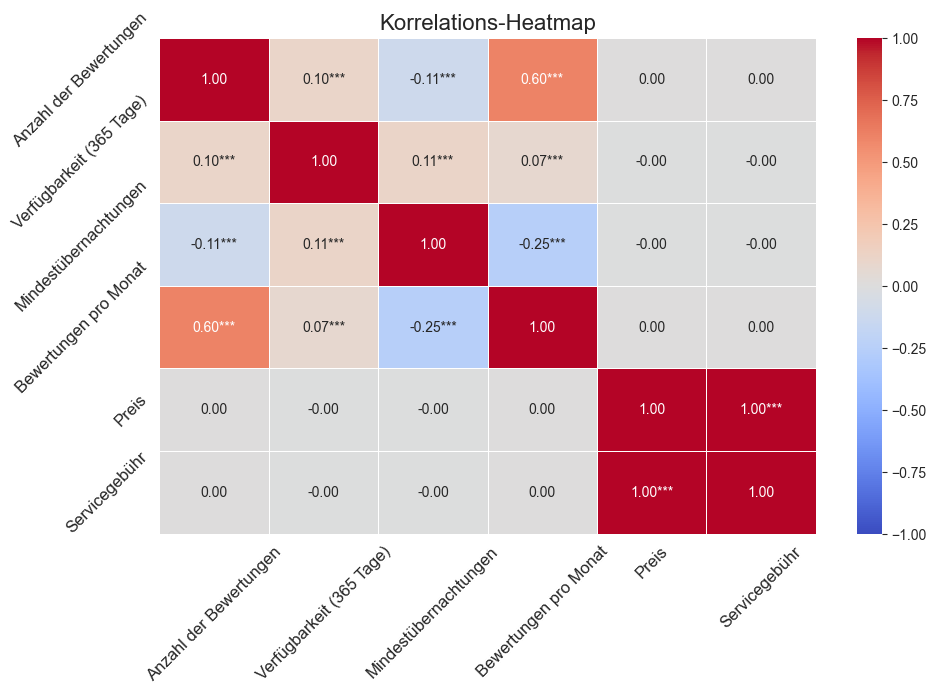

In [28]:
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Erstellen einer Matrix der Korrelation
correlation_matrix = airbnb_data[numerical_columns].corr()

# Leeres Array für die p-Werte
p_values = np.empty(correlation_matrix.shape)

# p-Werte berechnen
for row in correlation_matrix.index:
    for col in correlation_matrix.columns:
        if row == col:
            p_values[correlation_matrix.index.get_loc(row), correlation_matrix.columns.get_loc(col)] = np.nan
        else:
            _, p_value = pearsonr(airbnb_data[row], airbnb_data[col])
            p_values[correlation_matrix.index.get_loc(row), correlation_matrix.columns.get_loc(col)] = p_value

# Signifikanzlabels basierend auf den p-Werten
significance_labels = correlation_matrix.apply(lambda x: x.map(lambda y: ""))
for (i, j), p_value in np.ndenumerate(p_values):
    if not np.isnan(p_value):
        if p_value < 0.001:
            significance_labels.iloc[i, j] = "***"
        elif p_value < 0.01:
            significance_labels.iloc[i, j] = "**"
        elif p_value < 0.05:
            significance_labels.iloc[i, j] = "*"

# Kombinierte Annotation aus Korrelationswerten und Signifikanzlabels
annot = correlation_matrix.apply(lambda x: x.map('{:.2f}'.format)) + significance_labels

# Einstellen des Hintergrundstils für bessere Lesbarkeit
sns.set_style("whitegrid")

# Erstellen der Heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=annot, cmap='coolwarm', vmin=-1, vmax=1, fmt="s", linewidths=0.5, linecolor='white')

# Verbesserte Achsentitel und -beschriftungen für bessere Lesbarkeit
plt.title('Korrelations-Heatmap', fontsize=16)
merkmal_namen = [
    "Anzahl der Bewertungen", 
    "Verfügbarkeit (365 Tage)", 
    "Mindestübernachtungen", 
    "Bewertungen pro Monat", 
    "Preis", 
    "Servicegebühr"
]
ax = plt.gca()
ax.set_xticklabels(merkmal_namen, fontsize=12, horizontalalignment='center', rotation=45)
ax.set_yticklabels(merkmal_namen, fontsize=12, verticalalignment='center', rotation=45)
plt.tight_layout()

# Anzeigen der Heatmap
plt.show()


# Statistische Tests

Untersuchungen wurden durchgeführt, um festzustellen, ob es signifikante Unterschiede in der Verfügbarkeit über 365 Tage zwischen verschiedenen Gruppen von Unterkünften auf Airbnb gibt.

## Vergleich zwischen Gastgebern mit verifizierter Identität und denen ohne Verifizierung

Ein **T-Test** wurde durchgeführt, um den Durchschnitt der Verfügbarkeit zwischen Gastgebern, deren Identität verifiziert wurde, und denen, die unbestätigt sind, zu vergleichen. Die Ergebnisse zeigen, dass es keinen signifikanten Unterschied im Durchschnitt der Verfügbarkeit zwischen den beiden Gruppen gibt, **t(82209) = -1.645, p = .1**. Dies deutet darauf hin, dass die Überprüfung der Identität eines Gastgebers keinen Einfluss auf die Verfügbarkeit ihrer Unterkunft hat.

## Einfluss des Zimmertyps auf die Verfügbarkeit

Eine **ANOVA-Untersuchung** wurde durchgeführt, um den Einfluss des Zimmertyps auf die Verfügbarkeit zu analysieren. Die Ergebnisse zeigen eine sehr signifikante Wirkung des Zimmertyps auf die Verfügbarkeit, **F(3, 82209) = 47.227, p < .001**. Dies legt nahe, dass einige Zimmertypen durchschnittlich häufiger oder seltener verfügbar sind als andere.

## Einfluss der Stornierungsrichtlinie auf die Verfügbarkeit

Eine weitere **ANOVA-Untersuchung** wurde durchgeführt, um den Einfluss der Stornierungsrichtlinie auf die Verfügbarkeit zu analysieren. Die Ergebnisse zeigen, dass die Stornierungsrichtlinie keinen signifikanten Einfluss auf die Verfügbarkeit hat, **F(2, 82156) = 0.067, p = .935**. Dies bedeutet, dass unabhängig von der Stornierungsrichtlinie, die ein Gastgeber für seine Unterkunft gewählt hat, die durchschnittliche Verfügbarkeit über das Jahr hinweg relativ konstant bleibt.


In [32]:
# Statistische Tests
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# T-Test
# Gruppen erstellen
group_verified = airbnb_data[airbnb_data['host_identity_verified'] == 'verified']['availability_365']
group_not_verified = airbnb_data[airbnb_data['host_identity_verified'] == 'unconfirmed']['availability_365']

# Unabhängigen T-Test durchführen für 'host_identity_verified'
t_stat, p_value = stats.ttest_ind(group_verified, group_not_verified)

print(f"T-Statistik: {t_stat:.3f}")
print(f"P-Wert: {p_value:.3f}")

# Entscheidung basierend auf dem p-Wert
alpha = 0.05  # Signifikanzniveau
if p_value < alpha:
    print("Es gibt einen signifikanten Unterschied im Durchschnitt der Verfügbarkeit zwischen den beiden Gruppen.")
else:
    print("Es gibt keinen signifikanten Unterschied im Durchschnitt der Verfügbarkeit zwischen den beiden Gruppen.")
print("\n")
# ANOVA für 'room type'
model_room_type = ols('availability_365 ~ C(room_type)', data=airbnb_data).fit()
anova_table_room_type = sm.stats.anova_lm(model_room_type, typ=2)
print("ANOVA-Test für room type:")
print(anova_table_room_type)
print("\n")

# ANOVA für 'cancellation_policy'
model_cancellation_policy = ols('availability_365 ~ C(cancellation_policy)', data=airbnb_data).fit()
anova_table_cancellation_policy = sm.stats.anova_lm(model_cancellation_policy, typ=2)
print("ANOVA-Test für cancellation_policy:")
print(anova_table_cancellation_policy)


T-Statistik: -1.645
P-Wert: 0.100
Es gibt keinen signifikanten Unterschied im Durchschnitt der Verfügbarkeit zwischen den beiden Gruppen.


ANOVA-Test für room type:
                    sum_sq       df          F        PR(>F)
C(room_type)  2.527044e+06      3.0  47.226757  1.742846e-30
Residual      1.466300e+09  82209.0        NaN           NaN


ANOVA-Test für cancellation_policy:
                              sum_sq       df         F    PR(>F)
C(cancellation_policy)  2.383557e+03      2.0  0.066723  0.935455
Residual                1.467444e+09  82156.0       NaN       NaN


# ML-Modellierung für Airbnb-Unterkunftsverfügbarkeit mit Random Forest

## Einführung
Die ML-Modellierung zielt darauf ab, ein Machine Learning-Modell zu entwickeln, das die Verfügbarkeit von Unterkünften auf Airbnb über 365 Tage basierend auf bestimmten Merkmalen vorhersagen kann. Für dieses Projekt wurde das Random Forest Regressionsmodell gewählt, ein Ensemble-Lernansatz, der mehrere Entscheidungsbäume kombiniert, um eine robustere und genauere Vorhersage zu erreichen.

## Warum Random Forest?
Der Random Forest ist ein flexibles, einfaches und vielseitiges maschinelles Lernverfahren. Durch die Kombination von mehreren Entscheidungsbäumen bietet er eine verbesserte Vorhersagegenauigkeit und verhindert Overfitting.

## Auswahl der Variablen

- **Zimmertyp**: Art der angebotenen Unterkunft, die die Vorlieben der Gäste beeinflussen kann.
- **Bewertungen pro Monat**: Indikator für die Popularität einer Unterkunft.
- **Mindestübernachtungen**: Gibt die Gastgeberpräferenz an, ob kürzere oder längere Buchungen gewünscht sind.
- **Preis**: Kann Qualität, Lage und Beliebtheit der Unterkunft widerspiegeln.

## Leistungsbeurteilung

- **MSE**: Zeigt, wie nah unsere Vorhersagen an den tatsächlichen Werten liegen.
- **RMSE**: Gibt den durchschnittlichen Fehler in den gleichen Einheiten wie unser Ziel an.
- **R^2**: Zeigt an, wie gut unser Modell die tatsächlichen Schwankungen in den Daten erfasst.


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Daten vorbereiten
X = airbnb_data[['room_type', 'reviews_per_month', 'minimum_nights', 'price']]
y = airbnb_data['availability_365']

def prepare_data(df):
    df = df.copy()
    label_encoder = LabelEncoder()
    df['room_type'] = label_encoder.fit_transform(df['room_type'])
    return df, label_encoder.classes_

def train_and_evaluate(X_train, X_test, y_train, y_test):
    print("Training und Evaluierung des Modells beginnen...")
    rf_model = RandomForestRegressor(random_state=42)
    param_grid = {
        'n_estimators': [10, 50, 100, 200, 500]
    }
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                               scoring='neg_mean_squared_error', cv=4, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_n_estimators = grid_search.best_params_['n_estimators']
    print(f"\nDer optimale Wert für n_estimators ist: {best_n_estimators}\n")

    rf_model = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = rf_model.score(X_test, y_test)
    
    results = {
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Feature Importance": rf_model.feature_importances_
    }
    return results

X, classes = prepare_data(airbnb_data[['room_type', 'reviews_per_month', 'minimum_nights', 'price']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
results = train_and_evaluate(X_train, X_test, y_train, y_test)

# Bessere Ausgabe der Ergebnisse
print("\nErgebnisse:")
print("-----------------------------")
print(f"Mean Squared Error: {results['MSE']:.2f}")
print(f"Root Mean Squared Error: {results['RMSE']:.2f}")
print(f"R^2 Score: {results['R2']:.3f}")
print("\nFeature-Importanz:")
print("-----------------------------")
for feature, importance in zip(X.columns, results['Feature Importance']):
    print(f"{feature}: {importance:.3f}")


Training und Evaluierung des Modells beginnen...

Der optimale Wert für n_estimators ist: 500


Ergebnisse:
-----------------------------
Mean Squared Error: 12581.29
Root Mean Squared Error: 112.17
R^2 Score: 0.288

Feature-Importanz:
-----------------------------
room_type: 0.035
reviews_per_month: 0.336
minimum_nights: 0.089
price: 0.540


## Ergebnisse im Überblick

- **Durchschnittlicher Quadratfehler (MSE):** 
    - Unser Modell hat eine durchschnittliche quadratische Abweichung von `12581.294`.

- **Durchschnittlicher Fehler (RMSE):**
    - Unsere Vorhersagen weichen durchschnittlich `112` Tage ab.

- **Bestimmtheitsmaß (R^2):** 
    - Unser Modell erklärt etwa `28,8%` der Schwankungen.

- **Feature-Wichtigkeiten:** 
    - Der Preis und die Reviews pro Monat sind dabei am bedeutendsten.


## Modell-Interpretation

### Haupterkenntnisse
- **Preis:** Das dominanteste Merkmal. Höhere Preise könnten zu häufigerer Verfügbarkeit führen, da solche Unterkünfte möglicherweise seltener gebucht werden.
- **Bewertungen pro Monat:** Zeigen die Popularität der Unterkunft. Mehr Bewertungen könnten auf häufigere Buchungen und damit geringere Verfügbarkeit hinweisen.
- **Mindestnächte:** Weniger bedeutsam als die Anzahl der Bewertungen, was bedeutet, dass die Häufigkeit der Buchungen möglicherweise wichtiger ist als die Aufenthaltsdauer.
- **Zimmertyp:** Unterschiedliche Zimmertypen ziehen unterschiedliche Reisendengruppen an, wobei der Einfluss auf die Verfügbarkeit variiert.

### Abschlussgedanken
Unser Modell zeigt, dass verschiedene Faktoren die Verfügbarkeit beeinflussen. Für genauere Vorhersagen sind Kombinationen von Merkmalen nötig. Zukünftige Modelle könnten durch zusätzliche Daten, wie Lage, verbessert werden. Auch der Einfluss von saisonalen Faktoren sollte betrachtet werden.
